News Data exists: True
TSLA exists: True
NVDA exists: True
MSFT exists: True
META exists: True
GOOG exists: True
AMZN exists: True
Headline Length Descriptive Statistics:
count    55987.000000
mean        80.015254
std         56.126094
min         12.000000
25%         42.000000
50%         63.000000
75%         91.000000
max        512.000000
Name: headline_length, dtype: float64

Top 10 Publishers by Number of Articles:
publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


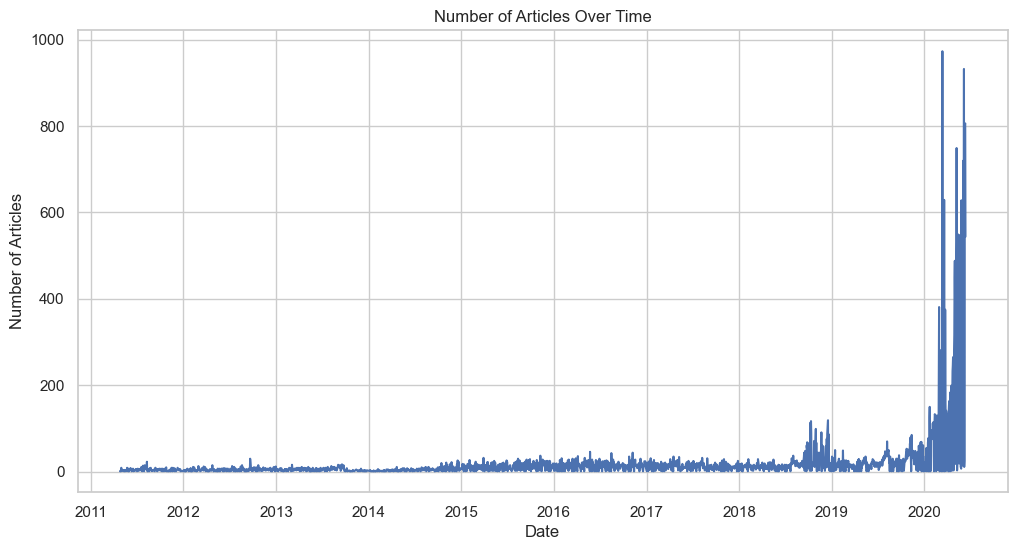

NameError: name 'CountVectorizer' is not defined

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os


# Optional: If you want to replace TA-Lib with pandas_ta
# import pandas_ta as ta

# Set plot style
sns.set(style='whitegrid')

# Define base directory (assumes your notebook is inside 'notebooks' folder)
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Paths to your data (relative to project root)
NEWS_DATA_PATH = os.path.join(base_dir, 'Data', 'Data', 'raw_analyst_ratings', 'raw_analyst_ratings.csv')
TSLA_PATH = os.path.join(base_dir, 'Data', 'Data', 'yfinance_data', 'yfinance_data', 'TSLA_historical_data.csv')
NVDA_PATH = os.path.join(base_dir, 'Data', 'Data', 'yfinance_data', 'yfinance_data', 'NVDA_historical_data.csv')
MSFT_PATH = os.path.join(base_dir, 'Data', 'Data', 'yfinance_data', 'yfinance_data', 'MSFT_historical_data.csv')
META_PATH = os.path.join(base_dir, 'Data', 'Data', 'yfinance_data', 'yfinance_data', 'META_historical_data.csv')
GOOG_PATH = os.path.join(base_dir, 'Data', 'Data', 'yfinance_data', 'yfinance_data', 'GOOG_historical_data.csv')
AMZN_PATH = os.path.join(base_dir, 'Data', 'Data', 'yfinance_data', 'yfinance_data', 'AMZN_historical_data.csv')

# Check file existence
paths = {
    'News Data': NEWS_DATA_PATH,
    'TSLA': TSLA_PATH,
    'NVDA': NVDA_PATH,
    'MSFT': MSFT_PATH,
    'META': META_PATH,
    'GOOG': GOOG_PATH,
    'AMZN': AMZN_PATH
}

for name, path in paths.items():
    print(f"{name} exists: {os.path.exists(path)}")

# Load news data
# Load without parse_dates, then convert explicitly
news_df = pd.read_csv(NEWS_DATA_PATH)

# Convert 'date' column to datetime explicitly
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# Drop rows with invalid 'date' if any
news_df.dropna(subset=['date'], inplace=True)

# Create 'publication_date' from 'date'
news_df['publication_date'] = news_df['date'].dt.date

# Load stock data
tsla_df = pd.read_csv(TSLA_PATH, parse_dates=['Date'])
nvda_df = pd.read_csv(NVDA_PATH, parse_dates=['Date'])
msft_df = pd.read_csv(MSFT_PATH, parse_dates=['Date'])
meta_df = pd.read_csv(META_PATH, parse_dates=['Date'])
goog_df = pd.read_csv(GOOG_PATH, parse_dates=['Date'])
amzn_df = pd.read_csv(AMZN_PATH, parse_dates=['Date'])

# Set Date as index for stock data
tsla_df.set_index('Date', inplace=True)
nvda_df.set_index('Date', inplace=True)
msft_df.set_index('Date', inplace=True)
meta_df.set_index('Date', inplace=True)
goog_df.set_index('Date', inplace=True)
amzn_df.set_index('Date', inplace=True)

# ------------------------
# Exploratory Data Analysis
# ------------------------

# 1. Basic statistics for headline length
news_df['headline_length'] = news_df['headline'].astype(str).apply(len)
print("Headline Length Descriptive Statistics:")
print(news_df['headline_length'].describe())

# 2. Count articles per publisher
publisher_counts = news_df['publisher'].value_counts()
print("\nTop 10 Publishers by Number of Articles:")
print(publisher_counts.head(10))

# 3. Publication date trend over time
pub_date_counts = news_df['publication_date'].value_counts().sort_index()
plt.figure(figsize=(12,6))
pub_date_counts.plot()
plt.title('Number of Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

# ------------------------
# Text Analysis (Topic Modeling)
# ------------------------

# Fill NaNs
texts = news_df['headline'].fillna('')

# Vectorize text data
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
dtm = vectorizer.fit_transform(texts)

# Apply LDA Topic Modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display top words per topic
for index, topic in enumerate(lda.components_):
    print(f"\nTopic {index + 1}:")
    top_indices = topic.argsort()[-10:][::-1]
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices]
    print(top_words)

# ------------------------
# Time Series Analysis of News Publishing
# ------------------------

# Using 'publication_date' for time series analysis
pub_counts_over_time = news_df['publication_date'].value_counts().sort_index()
plt.figure(figsize=(12,6))
pub_counts_over_time.plot()
plt.title('News Articles Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

# 4. Publishing times analysis
if 'publication_time' in news_df.columns:
    news_df['pub_hour'] = pd.to_datetime(news_df['publication_time']).dt.hour
    plt.figure(figsize=(10,6))
    sns.countplot(x='pub_hour', data=news_df)
    plt.title('Articles Published by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Articles')
    plt.show()

# 5. Publisher contribution analysis
top_publishers = news_df['publisher'].value_counts().head(10)
print("\nTop 10 Publishers:")
print(top_publishers)

# Extract domains if publisher looks like email
def extract_domain(publisher_name):
    match = re.search(r'@([\w.-]+)', str(publisher_name))
    return match.group(1) if match else publisher_name

news_df['domain'] = news_df['publisher'].apply(extract_domain)
domain_counts = news_df['domain'].value_counts()
print("\nTop Domains contributing to news:")
print(domain_counts.head(10))

# ------------------------
# Stock Data Analysis (Using pandas and pandas_ta if installed)
# ------------------------

# Example for Tesla
# Uncomment if pandas_ta is installed
# import pandas_ta as ta
# tsla_df['SMA_20'] = tsla_df['Close'].ta.sma(length=20)
# tsla_df['RSI'] = tsla_df['Close'].ta.rsi()
# macd = tsla_df['Close'].ta.macd()
# tsla_df['MACD'] = macd['MACD']
# tsla_df['MACD_signal'] = macd['MACDs']
# tsla_df['MACD_hist'] = macd['MACDh']

# Plot Close and SMA (if computed)
plt.figure(figsize=(14,7))
plt.plot(tsla_df['Close'], label='Close Price')
# plt.plot(tsla_df['SMA_20'], label='20-day SMA')
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 6. Additional Financial Metrics
tsla_df['Daily_Return'] = tsla_df['Close'].pct_change()
print("\nTesla Daily Returns Summary:")
print(tsla_df['Daily_Return'].describe())

print("Analysis complete.")